# [ATLAS-CONF-2013-102](https://cds.cern.ch/record/1601811/files/ATLAS-CONF-2013-102.pdf)

## ATLAS & CMS top mass combination at $\sqrt{s} = 7$ TeV

In [1]:
%matplotlib inline

In [2]:
from blue import Blue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('data/lhc_top_mass_7tev.txt', index_col='Exp')
df.T

Exp,ATLASljets,ATLASdilep,CMSljets,CMSdilep,CMSalljets,rho_exp,rho_lhc
Result,172.31,173.09,173.49,172.50,173.49,0.0,0.0
JSF,0.72,0.00,0.33,0.00,0.00,0.0,0.0
uJES,0.61,0.73,0.24,0.69,0.69,1.0,0.0
insituJES,0.29,0.31,0.02,0.35,0.35,1.0,0.0
intercalibJES,0.19,0.39,0.01,0.08,0.08,1.0,0.5
flavourJES,0.36,0.02,0.11,0.58,0.58,1.0,0.0
bJES,0.08,0.71,0.61,0.76,0.49,1.0,0.5
MC,0.33,0.48,0.02,0.04,0.19,1.0,1.0
Rad,0.45,0.37,0.30,0.58,0.33,1.0,1.0
CR,0.32,0.29,0.54,0.13,0.15,1.0,1.0


In [4]:
correlation = df.loc[['rho_exp', 'rho_lhc']].drop('Result', axis=1)
df = df.drop(['rho_exp', 'rho_lhc'])

In [5]:
def make_correlation_matrix(data):
    out = {}
    for i in data.columns:
        rho_exp = data.loc['rho_exp'][i]
        rho_lhc = data.loc['rho_lhc'][i]
        n_atlas, n_cms = 2, 3
        rho_atlas = np.full((n_atlas, n_atlas), rho_exp)
        rho_cms = np.full((n_cms, n_cms), rho_exp)
        rho_inter = np.full((n_atlas, n_cms), rho_lhc)
        corr_mat = np.block([
            [rho_atlas, rho_inter],
            [rho_inter.T, rho_cms]
        ])
        np.fill_diagonal(corr_mat, 1)
        out[i] = corr_mat
    return out

In [6]:
correlation = make_correlation_matrix(correlation)

In [7]:
blue = Blue(df, correlation)

In [8]:
blue.combined_result

173.28879459299233

In [9]:
uncertainties = pd.Series(blue.combined_uncertainties)

In [10]:
total_syst = np.sqrt((uncertainties.drop('Stats') ** 2).sum())
total_syst

0.91797502648660634

In [11]:
print(f'm_top = {blue.combined_result:.2f}'
      f' +/- {uncertainties["Stats"]:.2f} (stat)' 
      f' +/- {total_syst:.2f} (syst)')

m_top = 173.29 +/- 0.23 (stat) +/- 0.92 (syst)


In [12]:
blue.chi2_ndf

(1.7994655945280238, 4)

In [13]:
from scipy.stats import chi2
chi2.sf(*blue.chi2_ndf)

0.77258012492722461

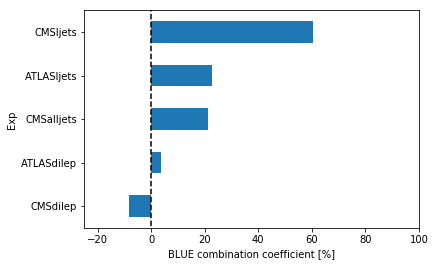

In [14]:
pd.Series(blue.weights * 100, index=blue.data.index).sort_values().plot.barh()
plt.vlines([0], -1, 5, linestyle='--')
ax = plt.gca()
ax.set(xlim=(-25, 100), xlabel='BLUE combination coefficient [%]');

[(-1, 1), <matplotlib.text.Text at 0x11a643c18>]

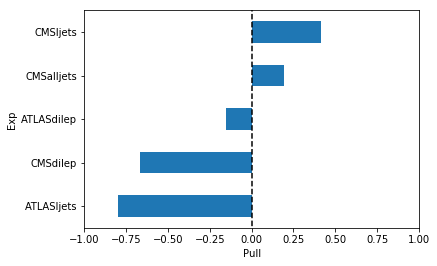

In [15]:
blue.pulls.sort_values().plot.barh()
plt.vlines([0], -1, 5, linestyle='--')
ax = plt.gca()
ax.set(xlim=(-1, 1), xlabel='Pull')

In [16]:
blue_weights = pd.Series(blue.weights, index=blue.data.index, name='BLUE weights')
intrinsic_inf_weights = pd.Series(blue.intrinsic_information_weights, index=blue.data.index, name='IIW')
intrinsic_inf_weights['Correlation'] = 1 - intrinsic_inf_weights.sum()
marginal_inf_weights = pd.Series(blue.marginal_information_weights, index=blue.data.index, name='MIW')
np.round(100 * pd.DataFrame([blue_weights, intrinsic_inf_weights, marginal_inf_weights]).T, 1)

,BLUE weights,IIW,MIW
ATLASdilep,3.7,34.0,0.2
ATLASljets,22.7,37.4,8.2
CMSalljets,21.4,45.0,4.3
CMSdilep,-8.2,38.9,0.6
CMSljets,60.5,79.2,25.0
Correlation,NaN,-134.4,NaN


In [17]:
_ = pd.DataFrame(blue.total_correlations,
                 index=blue.data.index,
                 columns=blue.data.index)
np.round(_, 2)

Exp,ATLASljets,ATLASdilep,CMSljets,CMSdilep,CMSalljets
Exp,,,,,
ATLASljets,1.00,0.63,0.26,0.18,0.16
ATLASdilep,0.63,1.00,0.36,0.25,0.24
CMSljets,0.26,0.36,1.00,0.64,0.56
CMSdilep,0.18,0.25,0.64,1.00,0.75
CMSalljets,0.16,0.24,0.56,0.75,1.00


In [18]:
channels = {
    'ljets': ['ATLASljets', 'CMSljets'],
    'dilep': ['ATLASdilep', 'CMSdilep'],
    'allhad': ['CMSalljets'],
}
channel_blue = Blue(df, correlation, observables=channels)
channel_blue.combined_result

{'allhad': 173.63605394165177,
 'dilep': 172.84659913598253,
 'ljets': 173.17553487639194}

In [19]:
np.round(channel_blue.observable_correlations, 2)

array([[ 1.  ,  0.72,  0.56],
       [ 0.72,  1.  ,  0.7 ],
       [ 0.56,  0.7 ,  1.  ]])

In [20]:
experiments = {
    'ATLAS': ['ATLASljets', 'ATLASdilep'],
    'CMS': ['CMSdilep', 'CMSljets', 'CMSalljets'],
}
experiment_blue = Blue(df, correlation, observables=experiments)
experiment_blue.combined_result

{'ATLAS': 172.69579665957849, 'CMS': 173.50077159132803}

In [21]:
np.round(experiment_blue.observable_correlations, 2)

array([[ 1.  ,  0.33],
       [ 0.33,  1.  ]])

In [22]:
blue[experiments['ATLAS']].combined_result

172.64916707178739

In [23]:
blue[experiments['CMS']].combined_result

173.58341686340304